# Homework 2

## Manyara Bonface Baraka - mbaraka

---

## Problem 1: Maximum Flow for Image Segmentation

### Question to Answer before writing code:

- **How does min-cut relate to this problem?**  
  Min-cut in a graph is a way of partitioning a graph into two disjoint subsets so that the total weight of the edges that cross the two subsets is minimized. For image segmentation, this directly maps to splitting an image into regions based on pixel similarities with the goal of separating pixels that belong to different objects or segments in the image.

- **Why is it true that the min-cut solution of a graph is equivalent to the max-flow solution?**  
  **The max-flow min-cut theorem** states that in any flow network, the maximum value of flow from the source to the sink node is equal to the total weight of the edges in the minimum cut that separates the source and the sink. Therefore, it is true that the min-cut of the graph is equivalent to the max-flow solution because:
  
  - A flow network indicates the effective flow of tokens through the edges from the source to the sink. The limit of how much the flow can be sent is determined by the minimum cut.
  - When an augmenting path (BFS or DFS) is found that increases the flow, it is essentially finding a way to push more tokens past the bottleneck (the min-cut).
  - Hence, if the maximum flow can be found—that is, the most tokens that can be pushed from the source to the sink—then the minimum capacity that could be removed to disconnect the sink from the source is also determined.

- **Using your knowledge of min-cut, explain why solving the maximum flow problem is a valid method for image segmentation.**  
  Image segmentation can be modeled as:
  
  - **Source node:** The set of pixels of the object or segment we need.
  - **Sink node:** The opposite segment of the source node, for instance, the background.
  - **Edges:** Neighboring pixels with weights based on pixel similarity.
  
  Therefore, applying maximum flow to the problem is valid because:
  
  - **Filtering pixels:** Max-flow helps in grouping similar pixels and reflecting connectivity based on edge weights.
  - **Segmentation:** Pixels not reachable from the source given the min-cut will be classified as the background.


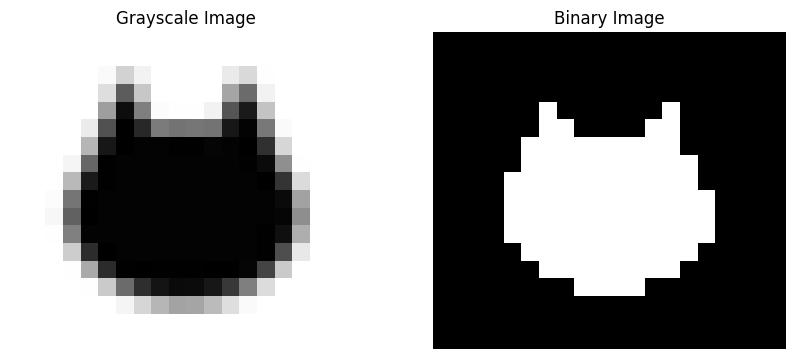

Maximum flow (segmentation result): 2.0


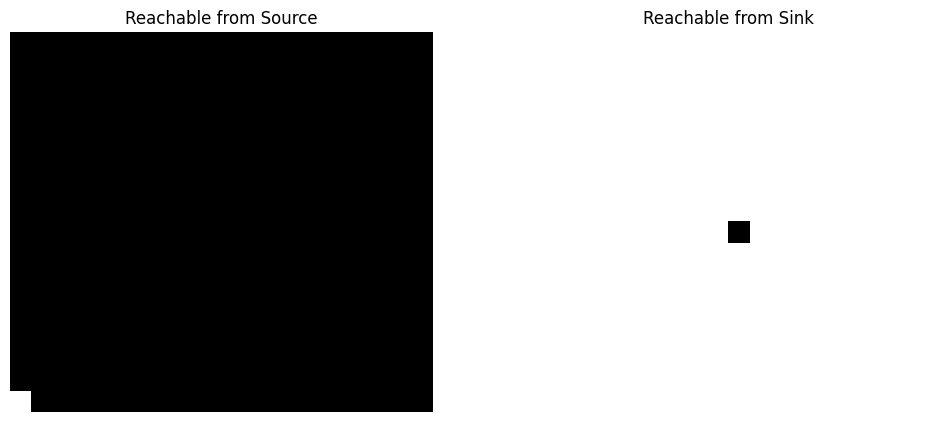

In [ ]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict

# Loading and processing image
img_path = 'problem1_cat.png'
img = Image.open(img_path)
img = ImageOps.grayscale(img)  # Convert to grayscale
# img.show()  # View the grayscale image

# Convert grayscale image to binary
img = np.array(img).astype(np.float32)  # Convert to ndarray
binary_img = (img < 128).astype(int)  # Binarize the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Grayscale Image')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Binary Image')
plt.imshow(binary_img, cmap='gray')
plt.axis('off')
plt.show()

# Define pixel index function
def pixel_index(x, y, width):
    return x * width + y

# Convert image to sparse graph
def image_to_graph(image):
    height, width = image.shape
    graph = defaultdict(dict)
    
    for i in range(height):
        for j in range(width):
            index = pixel_index(i, j, width)
            
            if j < width - 1:  # Right neighbor
                right_index = pixel_index(i, j + 1, width)
                weight = 1 / (1 + abs(image[i, j] - image[i, j + 1]))
                graph[index][right_index] = weight
                graph[right_index][index] = weight
            
            if i < height - 1:  # Down neighbor
                down_index = pixel_index(i + 1, j, width)
                weight = 1 / (1 + abs(image[i, j] - image[i + 1, j]))
                graph[index][down_index] = weight
                graph[down_index][index] = weight
    
    return graph, height, width

# Step 4: Implement BFS
def bfs(graph, source, sink, parent):
    visited = set()
    queue = deque([source])
    visited.add(source)
    
    while queue:
        u = queue.popleft()
        for v, capacity in graph[u].items():
            if v not in visited and capacity > 0:
                queue.append(v)
                visited.add(v)
                parent[v] = u
                if v == sink:
                    return True
    
    return False

# Ford-Fulkerson algorithm
def ford_fulkerson(graph, source, sink):
    parent = {}
    max_flow = 0
    residual_graph = {u: edges.copy() for u, edges in graph.items()}
    
    while bfs(residual_graph, source, sink, parent):
        path_flow = float('Inf')
        s = sink
        
        while s != source:
            path_flow = min(path_flow, residual_graph[parent[s]][s])
            s = parent[s]
        
        v = sink
        while v != source:
            u = parent[v]
            residual_graph[u][v] -= path_flow
            residual_graph[v][u] += path_flow
            v = parent[v]
        
        max_flow += path_flow
    
    return max_flow, residual_graph

# Define source and sink
def define_source_sink(image):
    height, width = image.shape
    source = pixel_index(height - 1, 0, width)  # Bottom-left corner
    sink = pixel_index(height // 2, width // 2, width)  # Center pixel
    return source, sink

# Reachable nodes
def find_reachable(graph, source):
    visited = set()
    queue = deque([source])
    visited.add(source)
    
    while queue:
        u = queue.popleft()
        for v, capacity in graph[u].items():
            if v not in visited and capacity > 0:
                queue.append(v)
                visited.add(v)
    
    return visited

# Main execution
if __name__ == "__main__":
    graph, height, width = image_to_graph(binary_img)  # Convert image to a sparse graph
    source, sink = define_source_sink(binary_img)  # source and sink
    max_flow, residual_graph = ford_fulkerson(graph, source, sink)  # Ford-Fulkerson

    print(f"Maximum flow (segmentation result): {max_flow}")

    # Find reachable nodes
    reachable_from_source = find_reachable(residual_graph, source)
    reachable_from_sink = find_reachable(residual_graph, sink)
    
    # Generate segmented images
    segmented_source = np.zeros_like(binary_img)
    segmented_sink = np.ones_like(binary_img)
    
    for pixel in reachable_from_source:
        x, y = divmod(pixel, width)
        segmented_source[x, y] = 1  # Foreground (black)
    
    for pixel in reachable_from_sink:
        x, y = divmod(pixel, width)
        segmented_sink[x, y] = 1  # Background (white)
    
    segmented_source[height - 1, 0] = 1  # Ensure source is marked
    segmented_sink[height // 2, width // 2] = 0  # Ensure sink is marked
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Reachable from Source')
    plt.imshow(segmented_source, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Reachable from Sink')
    plt.imshow(segmented_sink, cmap='gray')
    plt.axis('off')
    
    plt.show()


### Question to Answer After writing code:

**Time Complexity Analysis of Maximum Flow for Image Segmentation**

**Graph Construction (`image_to_graph`)**
- Iteration over all pixels in the image (`H × W` pixels).
- For each pixel, you add at most **two edges** (right and down neighbor).
- Since each edge is processed in constant time \(O(1)\), the total complexity is:  
  \[
  O(HW)
  \]



**Finding Augmenting Paths using BFS (`bfs`)**
- BFS explores all vertices (`V = HW`) and edges (`E ≈ 2HW`).
- BFS complexity:
  \[
  O(V + E) = O(HW + 2HW) = O(HW)
  \]



**Ford-Fulkerson Algorithm (`ford_fulkerson`)**
- Ford-Fulkerson runs **BFS repeatedly** to find augmenting paths.
- The worst-case number of augmenting paths is **equal to the maximum flow value**, which can be **at most \(O(HW)\)**.
- Each BFS call takes **\(O(HW)\)** time.
- Thus, the total complexity of Ford-Fulkerson is:
  \[
  O(\text{max flow} \times \text{BFS complexity}) = O(HW \times HW) = O(H^2W^2)
  \]



**Finding Reachable Nodes (`find_reachable`)**
- Runs BFS, which is **\(O(HW)\)**.



**The Total Time Complexity**
Since **(Ford-Fulkerson)** dominates all other steps, the total time complexity is:
\[
O(H^2 W^2)
\] 

---

**Optimizations to Reduce Runtime**
1. **Use Edmonds-Karp Algorithm instead of Ford-Fulkerson**  
   - Complexity: **\(O(H^3 W^3)\)**, better than Ford-Fulkerson.

2. **Use Push-Relabel Algorithm**
   - Complexity **\(O(H^3 W^3)\)** much faster.


----


**Ways to Reduce Space (Memory) Requirement**  

1. **Use Adjacency Lists Instead of Dictionary of Dictionaries**  
   - Replace `defaultdict(dict)` with a **list of lists** or **NumPy arrays** to store graph edges efficiently.  

2. **Avoid Deep Copying Residual Graph**  
   - Instead of making a full copy of `graph`, modify it **in-place** to save memory.  

3. **Use Boolean NumPy Arrays for Visited Nodes**  
   - Replace `set()` in BFS (`find_reachable`) with `visited = np.zeros(H*W, dtype=bool)` to reduce overhead.  

```

## Problem  2: Constraint Satisfaction for Map Coloring Problem

In [2]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def generate_map(n):
    points = [(random.random(), random.random()) for _ in range(n)]
    edges = []
    
    for i in range(n):
        distances = [(j, np.linalg.norm(np.array(points[i]) - np.array(points[j]))) for j in range(n) if j != i]
        distances.sort(key=lambda x: x[1])
        
        for j, _ in distances:
            if not any(intersect(points[i], points[j], points[a], points[b]) for a, b in edges):
                edges.append((i, j))
                break
    
    return points, edges

def intersect(p1, p2, p3, p4):
    def ccw(A, B, C):
        return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])
    return ccw(p1, p3, p4) != ccw(p2, p3, p4) and ccw(p1, p2, p3) != ccw(p1, p2, p4)

def backtracking(graph, colors, node, assignment):
    if node == len(graph):
        return assignment
    
    for color in colors:
        if all(assignment.get(neigh) != color for neigh in graph[node]):
            assignment[node] = color
            result = backtracking(graph, colors, node + 1, assignment)
            if result:
                return result
            assignment.pop(node)
    return None

def min_conflicts(graph, colors, max_steps=1000):
    assignment = {node: random.choice(colors) for node in graph}
    
    for _ in range(max_steps):
        conflicted = [node for node in graph if any(assignment[node] == assignment[neigh] for neigh in graph[node])]
        if not conflicted:
            return assignment
        node = random.choice(conflicted)
        assignment[node] = min(colors, key=lambda c: sum(assignment[neigh] == c for neigh in graph[node]))
    return None

def experiment():
    n_values = [10, 20, 30, 40, 50]
    algorithms = {"backtracking": backtracking, "min_conflicts": min_conflicts}
    k_values = [3, 4]
    results = {algo: {k: [] for k in k_values} for algo in algorithms}
    
    for n in n_values:
        points, edges = generate_map(n)
        graph = {i: set() for i in range(n)}
        for u, v in edges:
            graph[u].add(v)
            graph[v].add(u)
        
        for algo_name, algo in algorithms.items():
            for k in k_values:
                times = []
                for _ in range(5):
                    start_time = time.time()
                    algo(graph, list(range(k)), 0, {}) if algo_name == "backtracking" else algo(graph, list(range(k)))
                    times.append(time.time() - start_time)
                results[algo_name][k].append(np.mean(times))
    
    table_data = []
    for i, n in enumerate(n_values):
        row = [n] + [f"{results[algo][k][i]:.4f}" for algo in algorithms for k in k_values]
        table_data.append(row)
    
    headers = ["N", "Backtracking (3)", "Backtracking (4)", "Min-Conflicts (3)", "Min-Conflicts (4)"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    
if __name__ == "__main__":
    experiment()


+-----+--------------------+--------------------+---------------------+---------------------+
|   N |   Backtracking (3) |   Backtracking (4) |   Min-Conflicts (3) |   Min-Conflicts (4) |
+=====+====================+====================+=====================+=====================+
|  10 |             0      |             0.0002 |              0      |              0      |
+-----+--------------------+--------------------+---------------------+---------------------+
|  20 |             0      |             0.0002 |              0.0002 |              0      |
+-----+--------------------+--------------------+---------------------+---------------------+
|  30 |             0.0002 |             0.0002 |              0.0008 |              0.0007 |
+-----+--------------------+--------------------+---------------------+---------------------+
|  40 |             0.0002 |             0.0002 |              0.0007 |              0.0006 |
+-----+--------------------+--------------------+-----------

**Comments of the Results**

**Min-Conflicts Slightly Slower**  
- Unlike backtracking, min-conflicts **modifies an existing solution** instead of constructing one from scratch.  
- The algorithm **iterates over conflicts**, which adds computational steps, even for small graphs.  
- When conflicts are rare (as in small graphs), the algorithm mostly makes trivial moves, explaining why runtime remains low. 

**Backtracking is Faster**  
- With small instancesbacktracking performs well for small constraint.  
- The graph structure is **sparse** (few edges per node), reducing the number of constraints to check.  
- The algorithm **prunes invalid assignments early**, avoiding unnecessary searches.  

## Problem 7: Two Player Game

**Assumption:** Made an assumption the game has to make a max of 50 moves this is to avoid being in an infinite loop that i encountered.

In [3]:
import heapq
import copy
import time

class Node:
    def __init__(self, data, parent, level, fval):
        self.data = data
        self.parent = parent
        self.level = level
        self.fval = fval

    def __lt__(self, other):
        return self.fval < other.fval
    
    def state_string(self):
        """Convert state to string for hashing"""
        return ''.join([''.join(row) for row in self.data])

class AdversarialNPuzzle:
    def __init__(self, size):
        self.n = size
        self.visited = set()
        self.max_moves = 50  # Add a maximum move limit to prevent infinite games
        self.current_moves = 0
    
    def take_input(self):
        p = []
        for i in range(self.n):
            temp = input().split()
            p.append(temp)
        return p
    
    def find_blank_tile(self, state):
        for i in range(self.n):
            for j in range(self.n):
                if state[i][j] == '_':
                    return i, j
        return -1, -1  # Should not happen if the puzzle is valid
    
    def move_tile(self, state, x1, y1, x2, y2):
        new_state = copy.deepcopy(state)
        new_state[x1][y1], new_state[x2][y2] = new_state[x2][y2], new_state[x1][y1]
        return new_state
    
    def generate_child(self, node):
        children = []
        x, y = self.find_blank_tile(node.data)
        moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        for dx, dy in moves:
            newx, newy = x + dx, y + dy
            if 0 <= newx < self.n and 0 <= newy < self.n:
                new_state = self.move_tile(node.data, x, y, newx, newy)
                child = Node(new_state, node, node.level + 1, 0)
                children.append(child)
        return children
    
    def manhattan_distance(self, state, goal):
        distance = 0
        goal_dict = {}
        
        # Dictionary mapping each value to its position in the goal state
        for i in range(self.n):
            for j in range(self.n):
                if goal[i][j] != '_':
                    goal_dict[goal[i][j]] = (i, j)
        
        # Manhattan distance for each tile
        for i in range(self.n):
            for j in range(self.n):
                if state[i][j] != '_' and state[i][j] in goal_dict:
                    goal_x, goal_y = goal_dict[state[i][j]]
                    distance += abs(i - goal_x) + abs(j - goal_y)
        
        return distance
    
    def f_score(self, state, goal):
        return self.manhattan_distance(state, goal)
    
    def is_end(self, state, goal, opponent_goal):
        # current state matches either goal state or if max moves reached
        return state == goal or state == opponent_goal or self.current_moves >= self.max_moves
    
    def minimax(self, node, depth, is_maximizing, alpha, beta, goal, opponent_goal, memo=None):
        if memo is None:
            memo = {}
        
        # unique key for the current state and player
        state_str = ''.join([''.join(row) for row in node.data])
        key = (state_str, is_maximizing, depth)
        
        # If we've seen this state before at the same depth and for the same player, return the cached result
        if key in memo:
            return memo[key]
        
        # Terminal condition: reached max depth or game is over
        if depth == 0 or self.is_end(node.data, goal, opponent_goal):
            # For the agent (minimizing player), we want to minimize the distance to our goal
            # For the opponent (maximizing player), they want to maximize the distance to agent's goal
            if is_maximizing:
                result = -self.f_score(node.data, opponent_goal)  # Opponent tries to reach opponent_goal
            else:
                result = self.f_score(node.data, goal)  # Agent tries to minimize distance to agent's goal
            memo[key] = result
            return result
        
        children = self.generate_child(node)
        
        # No valid moves
        if not children:
            memo[key] = 0
            return 0
            
        if is_maximizing:
            max_eval = float('-inf')
            for child in children:
                eval = self.minimax(child, depth - 1, False, alpha, beta, goal, opponent_goal, memo)
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            memo[key] = max_eval
            return max_eval
        else:
            min_eval = float('inf')
            for child in children:
                eval = self.minimax(child, depth - 1, True, alpha, beta, goal, opponent_goal, memo)
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            memo[key] = min_eval
            return min_eval
    
    def get_best_move(self, current, is_agent_turn, goal, opponent_goal, search_depth=3):
        """Find the best move for the current player"""
        # dictionary to cache results
        memo = {}
        
        best_move = None
        
        if is_agent_turn:  # Agent (minimizing player)
            best_value = float('inf')
            for child in self.generate_child(current):
                child_state_str = ''.join([''.join(row) for row in child.data])
                
                # Skip if this state has been visited before (to avoid cycles)
                if child_state_str in self.visited:
                    continue
                    
                move_value = self.minimax(child, search_depth, False, float('-inf'), float('inf'), 
                                         goal, opponent_goal, memo)
                if move_value < best_value:
                    best_value = move_value
                    best_move = child
        else:  # Opponent (maximizing player)
            best_value = float('-inf')
            for child in self.generate_child(current):
                child_state_str = ''.join([''.join(row) for row in child.data])
                
                # Skip if this state has been visited before (to avoid cycles)
                if child_state_str in self.visited:
                    continue
                    
                move_value = self.minimax(child, search_depth, True, float('-inf'), float('inf'), 
                                         goal, opponent_goal, memo)
                if move_value > best_value:
                    best_value = move_value
                    best_move = child
        
        # If no valid moves found (all lead to visited states), pick the first available move
        if best_move is None and self.generate_child(current):
            best_move = self.generate_child(current)[0]
            
        return best_move
    
    def play(self):
        print("Enter the start state:")
        start = self.take_input()
        print("Enter the agent's goal state:")
        goal = self.take_input()
        print("Enter the opponent's goal state:")
        opponent_goal = self.take_input()
        
        # Initialize game state
        current = Node(start, None, 0, 0)
        is_agent_turn = True
        self.visited = set()  # Reset visited states
        self.current_moves = 0
        
        print("\nStarting Game:")
        for row in current.data:
            print(" ".join(row))
        print("\n")
        
        # Main game loop
        while not self.is_end(current.data, goal, opponent_goal):
            # Keep track of visited states to avoid cycles
            current_state_str = ''.join([''.join(row) for row in current.data])
            self.visited.add(current_state_str)
            
            # Make move based on player
            if is_agent_turn:
                print("Agent's move:")
                start_time = time.time()
                best_move = self.get_best_move(current, True, goal, opponent_goal)
                end_time = time.time()
                print(f"Move calculated in {end_time - start_time:.2f} seconds")
            else:
                print("Opponent's move:")
                start_time = time.time()
                best_move = self.get_best_move(current, False, goal, opponent_goal)
                end_time = time.time()
                print(f"Move calculated in {end_time - start_time:.2f} seconds")
            
            # Check if a valid move was found
            if best_move is None:
                print("No valid moves available. Game ends in a draw.")
                break
            
            # Update game state
            current = best_move
            self.current_moves += 1
            
            # Display current state
            for row in current.data:
                print(" ".join(row))
            print(f"Move {self.current_moves}/{self.max_moves}\n")
            
            # Switch player turn
            is_agent_turn = not is_agent_turn
        
        # Determine winner
        if current.data == goal:
            print("Agent wins!")
        elif current.data == opponent_goal:
            print("Opponent wins!")
        elif self.current_moves >= self.max_moves:
            print("Game ended due to maximum moves reached. It's a draw!")
        else:
            print("Game ended in a draw.")

# Create & run the game
puzzle = AdversarialNPuzzle(3)
puzzle.play()

Enter the start state:
Enter the agent's goal state:
Enter the opponent's goal state:

Starting Game:
1 _ 3
4 2 5
7 8 6


Agent's move:
Move calculated in 0.00 seconds
1 3 _
4 2 5
7 8 6
Move 1/50

Opponent's move:
Move calculated in 0.00 seconds
1 3 5
4 2 _
7 8 6
Move 2/50

Agent's move:
Move calculated in 0.00 seconds
1 3 5
4 2 6
7 8 _
Move 3/50

Opponent's move:
Move calculated in 0.00 seconds
1 3 5
4 2 6
7 _ 8
Move 4/50

Agent's move:
Move calculated in 0.00 seconds
1 3 5
4 _ 6
7 2 8
Move 5/50

Opponent's move:
Move calculated in 0.00 seconds
1 _ 5
4 3 6
7 2 8
Move 6/50

Agent's move:
Move calculated in 0.00 seconds
_ 1 5
4 3 6
7 2 8
Move 7/50

Opponent's move:
Move calculated in 0.00 seconds
4 1 5
_ 3 6
7 2 8
Move 8/50

Agent's move:
Move calculated in 0.00 seconds
4 1 5
7 3 6
_ 2 8
Move 9/50

Opponent's move:
Move calculated in 0.00 seconds
4 1 5
7 3 6
2 _ 8
Move 10/50

Agent's move:
Move calculated in 0.00 seconds
4 1 5
7 _ 6
2 3 8
Move 11/50

Opponent's move:
Move calculated in 

## Problem 9: Connect Four
**Is Connect Four a Minimax Game?**


Yes, Connect Four is a minimax game. Minimax applies to two-player, zero-sum, turn-based games where players alternate moves, and each player's objective is to maximize their own advantage while minimizing their opponent’s advantage. In Connect Four:
- The "maximizing" player (e.g., 'X') tries to make a move that maximizes their chances of winning.
- The "minimizing" player (e.g., 'O') tries to counter by making a move that minimizes the maximizing player’s advantage.
- The game has a clear win/loss condition, and each state of the board can be evaluated based on potential wins, blocks, or future opportunities.
- There is perfect information (both players see the entire board), and there is no element of randomness.

Therfore this makes Connect Four a perfect fit for minimax.


In [4]:
import copy 
import time 

# Check if a given player ('x' or 'o') has 4 in a row on the board.
def check_win(board, player):
    n = len(board)  # Board is n x n (here, n=6)
    
    # Check horizontal (rows)
    for i in range(n):
        for j in range(n - 3):
            if all(board[i][j+k] == player for k in range(4)):
                return True

    # Check vertical (columns)
    for j in range(n):
        for i in range(n - 3):
            if all(board[i+k][j] == player for k in range(4)):
                return True

    # Check diagonal down-right
    for i in range(n - 3):
        for j in range(n - 3):
            if all(board[i+k][j+k] == player for k in range(4)):
                return True

    # Check diagonal up-right
    for i in range(3, n):
        for j in range(n - 3):
            if all(board[i-k][j+k] == player for k in range(4)):
                return True

    return False

# Terminal check: game over if one player wins or no moves left.
def is_terminal(board):
    if check_win(board, 'x') or check_win(board, 'o'):
        return True
    if not any('.' in row for row in board):
        return True  # Board is full: draw.
    return False

# Evaluate terminal state: +1 if X wins, -1 if O wins, 0 otherwise.
def evaluate(board):
    if check_win(board, 'x'):
        return 1 # wins 
    elif check_win(board, 'o'):
        return -1 # loses 
    else:
        return 0 # draw 

# Get all legal moves (empty cells) as (row, col) tuples.
def get_legal_moves(board):
    moves = []
    rows = len(board)
    columns = len(board[0])
    # Loop through each column.
    for col in range(columns):
        # If the top cell is not empty, the column is full.
        if board[0][col] != '.':
            continue
        # Otherwise, find the bottom-most empty cell in this column.
        for row in range(rows - 1, -1, -1):
            if board[row][col] == '.':
                moves.append((row, col))
                break  # Stop after finding the first empty cell.
    return moves

def apply_move(board, move, player):
    new_board = copy.deepcopy(board)
    i, j = move
    new_board[i][j] = player
    return new_board

# The minimax algorithm:
# Minimax algorithm without pruning
def minimax(board, isMaximizing, depth=4):
    if is_terminal(board) or depth == 0:
        return evaluate(board), None

    if isMaximizing:
        maxEval, best_move = -float('inf'), None
        for move in get_legal_moves(board):
            eval, _ = minimax(apply_move(board, move, 'x'), False, depth - 1)
            if eval > maxEval:
                maxEval, best_move = eval, move
        return maxEval, best_move
    else:
        minEval, best_move = float('inf'), None
        for move in get_legal_moves(board):
            eval, _ = minimax(apply_move(board, move, 'o'), True, depth - 1)
            if eval < minEval:
                minEval, best_move = eval, move
        return minEval, best_move

# Minimax algorithm with pruning
def minimax_alpha_beta(board, isMaximizing, alpha, beta, depth=4):
    if is_terminal(board) or depth == 0:
        return evaluate(board), None

    if isMaximizing:
        maxEval, best_move = -float('inf'), None
        for move in get_legal_moves(board):
            eval, _ = minimax_alpha_beta(apply_move(board, move, 'x'), False, alpha, beta, depth - 1)
            if eval > maxEval:
                maxEval, best_move = eval, move
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return maxEval, best_move
    else:
        minEval, best_move = float('inf'), None
        for move in get_legal_moves(board):
            eval, _ = minimax_alpha_beta(apply_move(board, move, 'o'), True, alpha, beta, depth - 1)
            if eval < minEval:
                minEval, best_move = eval, move
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return minEval, best_move

if __name__ == "__main__": 

    # The current 6x6 board. 'x' and 'o' represent pieces; '.' represents an empty cell. 
    board = [
        ['.', '.', '.', '.', '.', '.'], 
        ['x', 'x', 'o', '.', '.', '.'], 
        ['o', 'o', 'o', 'x', '.', '.'], 
        ['o', 'x', 'o', 'x', 'x', '.'], 
        ['x', 'o', 'x', 'o', 'o', 'o'], 
        ['o', 'x', 'x', 'o', 'x', 'x'], 
    ] # X's turn 

    # Use minimax (assuming it is X's turn, so isMaximizing=True) to choose the best move. 
    print("Minimax without Alpha-Beta Pruning:")
    starttime = time.time() 
    score, best_move = minimax(board, True) 
    endtime = time.time()
    print("Time taken:", endtime - starttime) 
    print("Best move for X:", best_move, "with score:", score)

    print("\nMinimax with Alpha-Beta Pruning:")
    starttime = time.time()
    score, best_move = minimax_alpha_beta(board, True, -float('inf'), float('inf')) 
    endtime = time.time() 
    print("Time taken:", endtime - starttime) 
    print("Best move for X:", best_move, "with score:", score) 


Minimax without Alpha-Beta Pruning:
Time taken: 0.23055696487426758
Best move for X: (2, 4) with score: 1

Minimax with Alpha-Beta Pruning:
Time taken: 0.03755521774291992
Best move for X: (2, 4) with score: 1


**How to Convert Connect Four to an Expectimax Problem?**

To convert Connect Four into an Expectimax problem, we will have to introduce randomness or uncertainty into the game. A rational way to do this would be:

- **Introducing Random Moves:** Instead of the opponent playing optimally (as in minimax), we could assume that they play randomly with some probability. For example, instead of always choosing the best move, the opponent selects a move based on a probability distribution over available moves.
- **Introducing a Stochastic Drop Mechanism:** Instead of pieces always falling to the lowest available row, we could introduce a probability that the piece might bounce or land in a slightly different position.

In Expectimax, instead of assuming the opponent always makes the best move, we take the **expected value** over all possible moves the opponent could make, weighted by their likelihood.
